# Regression Localized by kNN clusters

In [71]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *

from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings('ignore')
#warnings.resetwarnings()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Static data
counties, counties_date = load_counties()

In [3]:
deaths_df = get_cum_deaths_dataframe(n_days=28, onset_threshold=3, ma_width=7, time_series=True)
days = [d for d in deaths_df.columns if d[:4] == 'day_']

/Users/Ronan/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
../src/data_loader/data_loader.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_df.dropna(subset=['FIPS'], inplace=True)


In [43]:
ddf = deaths_df.copy()
ddf = ddf.merge(counties[counties.columns.difference(ddf.columns).to_list() + ['FIPS']], on='FIPS')

## Edits
ddf = ddf.rename({
    'Density per square mile of land area - Population': 'POP Density',
    'Density per square mile of land area - Housing units': 'Housing Density',
}, axis=1)

## Normalized Mobility
ddf['OD_at_onset_normalized'] = ddf['OD_at_onset'] / ddf['OD_baseline']
ddf['OD_2wk_before_onset_normalized'] = ddf['OD_2wk_before_onset'] / ddf['OD_baseline']
ddf['OD_2wk_after_onset_normalized'] = ddf['OD_2wk_after_onset'] / ddf['OD_baseline']

## Black, african, hispanic, native american population
ddf['BAHN'] = ddf[['H_FEMALE', 'H_MALE', 'BA_FEMALE', 'BA_MALE', 'IA_MALE', 'IA_FEMALE']].sum(axis=1)

pop_vars = [
    'day_28',
    'Beds',
    'HospCt',
    'Total_age65plus',
    'POVALL_2018',
    'BAHN',
    'BA_MALE',
]
ddf[[l + '_normalized' for l in pop_vars]] = ddf[pop_vars].div(ddf['POP_ESTIMATE_2018'], axis=0)

## Normalize others
log_vars = [
    'day_28_normalized',
    'day_28',
    'OD_at_onset',
    'OD_baseline',
    'POP_ESTIMATE_2018',
    'POP Density',
    'Housing Density',
    'BAHN',
    'BA_MALE_normalized',
]
## Compensate for 0 being a possible value
ddf[[l + ' (log)' for l in log_vars]] = ddf[log_vars].transform('log')


##
UPPER_CUTOFF = np.inf
LOWER_CUTOFF = 4

ddf = ddf[ddf[days[-1]] >= LOWER_CUTOFF]
ddf = ddf[ddf[days[-1]] <= UPPER_CUTOFF]

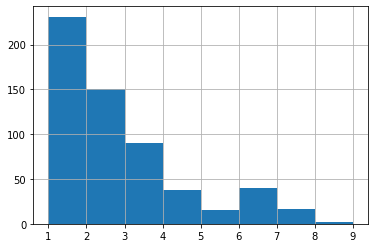

In [5]:
ddf['Rural-urban_Continuum Code_2013'].hist(bins=[1,2,3,4,5,6,7,8,9])

## BAHN

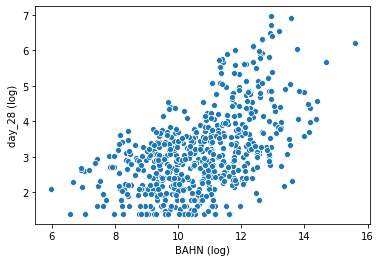

In [35]:
sns.scatterplot(x = 'BAHN (log)',y='day_28 (log)',data=ddf)

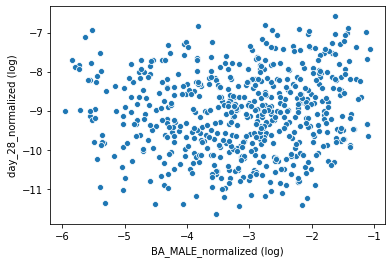

In [44]:
sns.scatterplot(x = 'BA_MALE_normalized (log)',y='day_28_normalized (log)',data=ddf)

## All RUCCS

In [7]:
strat_df = ddf.copy()#[ddf['Rural-urban_Continuum Code_2013'] == RUCC]

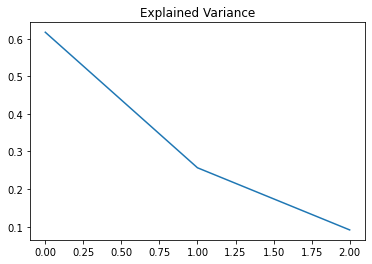

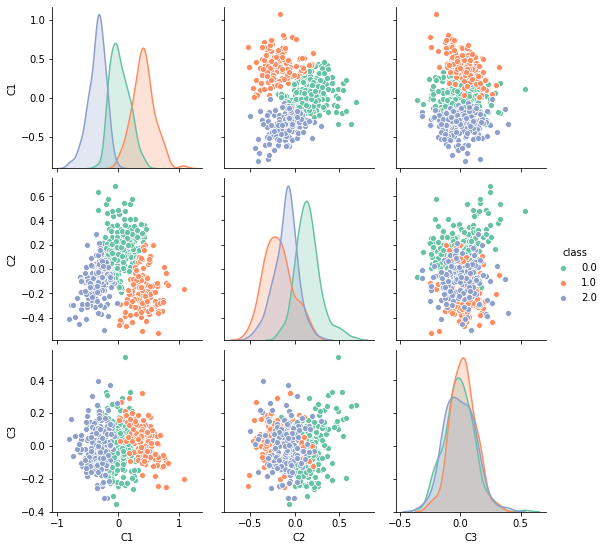

In [22]:
#vars = ['POP_ESTIMATE_2018 (log)', 'OD_baseline (log)']
vars = [
    'OD_baseline (log)',
    'OD_at_onset_normalized',
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',
    'POP_ESTIMATE_2018 (log)',
    'onset_relative',
]
X = strat_df[vars].values.copy()
XX = X - X.min(axis=0)[None,:]
XX /= XX.max(axis=0)[None,:]
pca = PCA(n_components=3, svd_solver='full')
XXX = pca.fit_transform(XX)

clustering = KMeans(n_clusters=3, random_state=0).fit(XXX)
#clustering = AgglomerativeClustering(n_clusters=6, linkage='average', affinity='euclidean').fit(XX)
strat_df['strat_class'] = clustering.labels_

plt.plot(np.arange(XXX.shape[1]), pca.explained_variance_ratio_); plt.title('Explained Variance')

g = sns.pairplot(
    vars=['C1','C2','C3'],
    data=pd.DataFrame(data=np.hstack((XXX, clustering.labels_[:,None])),columns=['C1','C2','C3','class']),
    hue='class',
    palette="Set2",
)

plt.show()

### Investigating confounder effects

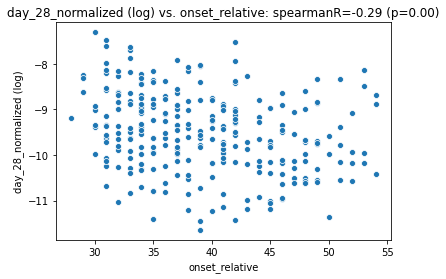

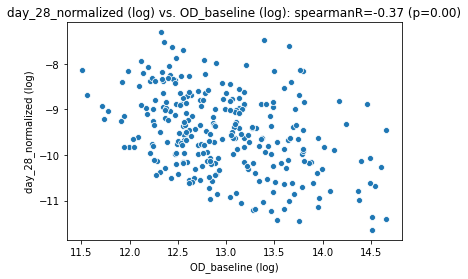

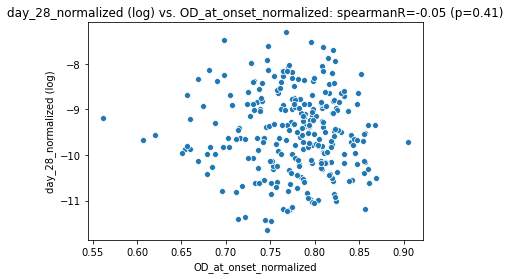

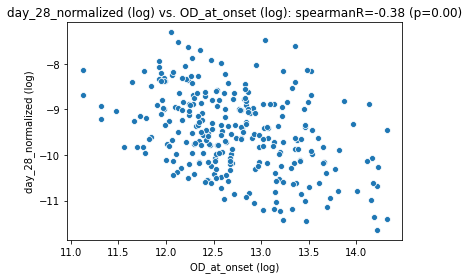

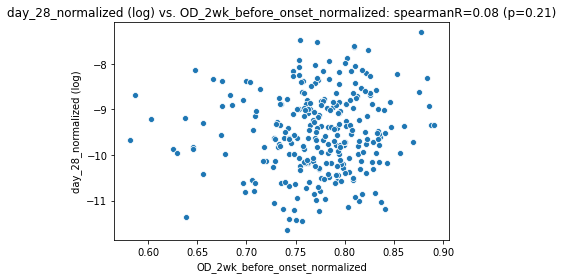

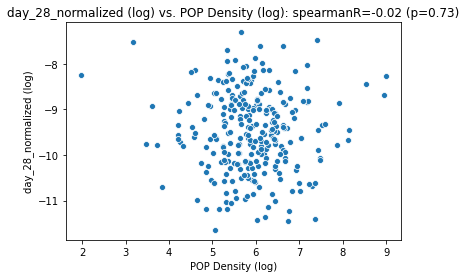

In [26]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
#     'Housing Density (log)',# s,
#     'POP_ESTIMATE_2018 (log)',# s,
#     'Beds_normalized',# s,
#     'HospCt_normalized',# s,
#     'Total_age65plus_normalized',# s,
#     'POVALL_2018_normalized',# s
#     'BAHN_normalized',# s
]
strat_class = 0
data = strat_df[strat_df['strat_class'] == strat_class]
y = 'day_28_normalized (log)'
for x in predictor_vars:
    fig,ax = plt.subplots()
    ax = sns.scatterplot(
        x=x,
        y=y,
        data=data,
        ax=ax
    )
    r,p = spearmanr(
        data[x],
        data[y]
    )
    ax.set_title(f'{y} vs. {x}: spearmanR={r:.2f} (p={p:.2f})')

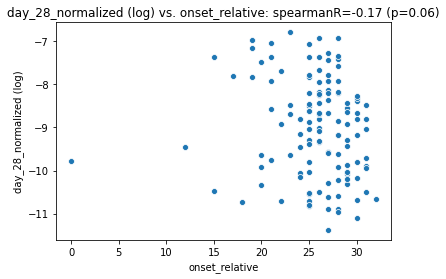

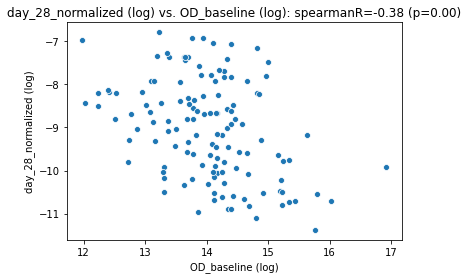

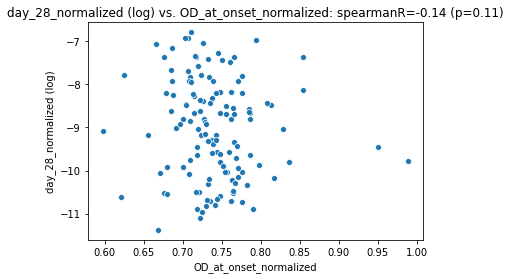

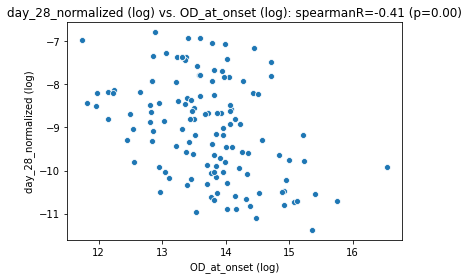

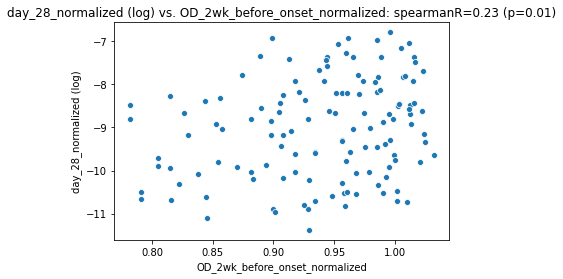

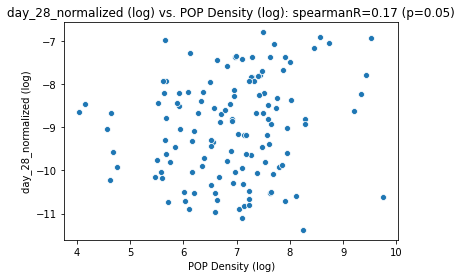

In [27]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
]
strat_class = 1
data = strat_df[strat_df['strat_class'] == strat_class]
y = 'day_28_normalized (log)'
for x in predictor_vars:
    fig,ax = plt.subplots()
    ax = sns.scatterplot(
        x=x,
        y=y,
        data=data,
        ax=ax
    )
    r,p = spearmanr(
        data[x],
        data[y]
    )
    ax.set_title(f'{y} vs. {x}: spearmanR={r:.2f} (p={p:.2f})')

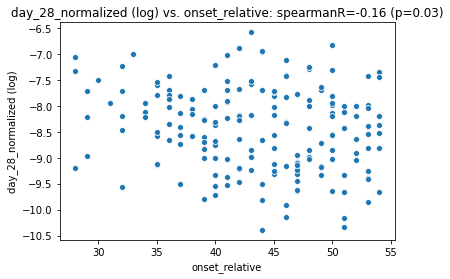

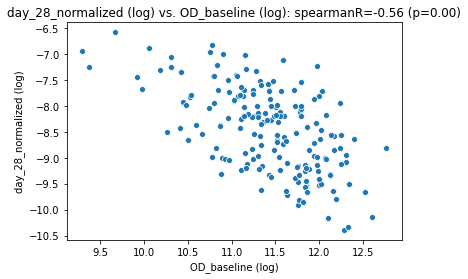

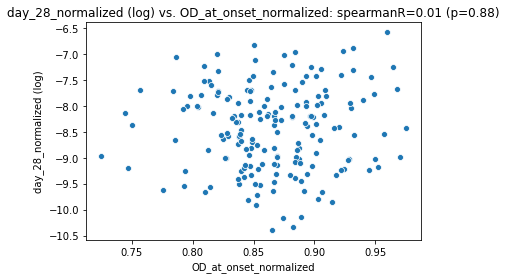

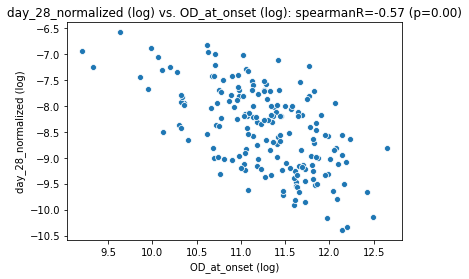

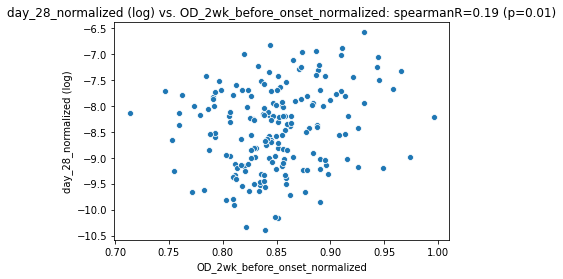

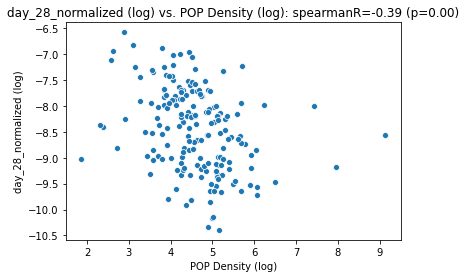

In [28]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
]
strat_class = 2
data = strat_df[strat_df['strat_class'] == strat_class]
y = 'day_28_normalized (log)'
for x in predictor_vars:
    fig,ax = plt.subplots()
    ax = sns.scatterplot(
        x=x,
        y=y,
        data=data,
        ax=ax
    )
    r,p = spearmanr(
        data[x],
        data[y]
    )
    ax.set_title(f'{y} vs. {x}: spearmanR={r:.2f} (p={p:.2f})')

## Local Points

In [62]:
from sklearn.metrics import pairwise_distances
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import TweedieRegressor, LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import statsmodels.api as sm

/Users/Ronan/miniconda3/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/Users/Ronan/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [54]:
X_dists = pairwise_distances(XXX[:,:2])

In [57]:
X0_idx = 39 ## Close to center of cluster
row = X_dists[X0_idx]
row /= np.max(row)

In [117]:
predictor_vars = [
#     'onset_relative',# s
#     'OD_baseline (log)',# s,
#     'OD_at_onset_normalized',# s,
#     'OD_at_onset (log)',
#     'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
#     'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
target_var = 'day_28_normalized'

In [118]:
nn_lens = []
r2s = []
epsilons = np.arange(0.05,0.15,0.005)
for epsilon in epsilons:
    nn = np.where(row < epsilon)[0]

    X = strat_df[predictor_vars].copy().to_numpy()[nn]
    y = strat_df[target_var].copy().to_numpy()[nn]
    
    scaler = MinMaxScaler()
    XX = scaler.fit_transform(X)

    glm = sm.GLM(y, sm.add_constant(XX), family=sm.families.Gaussian(sm.families.links.log))
    glm = glm.fit()
    
    print(pd.DataFrame(np.vstack((glm.pvalues[1:][None,:],glm.params[1:][None,:])), columns=predictor_vars).rename(index={0:'pvalues', 1:'coef'}))
    break
    r2s.append(r2_score(y, glm.predict(sm.add_constant(XX))))
    nn_lens.append(len(nn))

         POP Density (log)  Housing Density (log)  Beds_normalized  \
pvalues           1.000000               1.000000         1.000000   
coef           -134.311902             122.248015        -6.624868   

         HospCt_normalized  Total_age65plus_normalized  \
pvalues           1.000000                    1.000000   
coef              2.086097                   -2.591029   

         POVALL_2018_normalized  BAHN_normalized  
pvalues                 1.00000         1.000000  
coef                   -6.07708         3.324869  


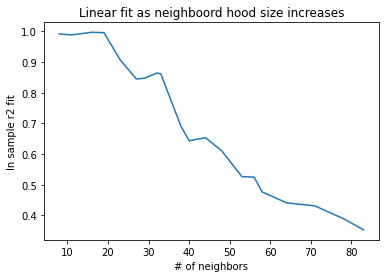

In [80]:
plt.plot(nn_lens, r2s)#, c=nn_lens)
plt.xlabel('# of neighbors')
plt.ylabel('In sample r2 fit')
plt.title('Linear fit as neighboord hood size increases')
plt.show()

In [81]:
predictor_vars = [
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
target_var = 'day_28_normalized'

In [82]:
nn_lens = []
r2s = []
epsilons = np.arange(0.05,0.15,0.005)
for epsilon in epsilons:
    nn = np.where(row < epsilon)[0]

    X = strat_df[predictor_vars].copy().to_numpy()[nn]
    y = strat_df[target_var].copy().to_numpy()[nn]
    
    scaler = MinMaxScaler()
    XX = scaler.fit_transform(X)

    glm = sm.GLM(y, sm.add_constant(XX), family=sm.families.Gaussian(sm.families.links.log))
    glm = glm.fit()
    
    r2s.append(r2_score(y, glm.predict(sm.add_constant(XX))))
    nn_lens.append(len(nn))

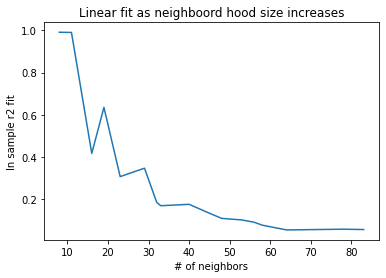

In [83]:
plt.plot(nn_lens, r2s)#, c=nn_lens)
plt.xlabel('# of neighbors')
plt.ylabel('In sample r2 fit')
plt.title('Linear fit as neighboord hood size increases')
plt.show()

## With modified weights

In [85]:
predictor_vars = [
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
target_var = 'day_28_normalized'

In [121]:
nn_lens = []
r2s = []
epsilons = np.arange(0.05,0.15,0.005)
for epsilon in epsilons:
    nn = np.where(row < epsilon)[0]

    X = strat_df[predictor_vars].copy().to_numpy()[nn]
    y = strat_df[target_var].copy().to_numpy()[nn]
    
    scaler = MinMaxScaler()
    XX = scaler.fit_transform(X)

    weights = np.exp(-1*row[nn])
    glm = sm.GLM(y, sm.add_constant(XX), family=sm.families.Gaussian(sm.families.links.log),var_weights=1/weights)
    glm = glm.fit()
    
    r2s.append(r2_score(y, glm.predict(sm.add_constant(XX)), sample_weight=weights))
    nn_lens.append(len(nn))

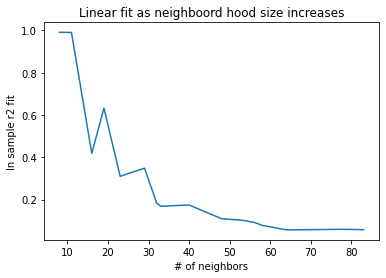

In [122]:
plt.plot(nn_lens, r2s)#, c=nn_lens)
plt.xlabel('# of neighbors')
plt.ylabel('In sample r2 fit')
plt.title('Linear fit as neighboord hood size increases')
plt.show()

## Looking at the nearest neighbors

In [102]:
nn = np.where(row < epsilons[0])[0]

In [103]:
nn

array([ 39, 122, 190, 294, 308, 476, 514, 532])

In [114]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
target_var = 'day_28_normalized'

In [115]:
strat_df.iloc[nn][predictor_vars + [target_var]]

,onset_relative,OD_baseline (log),OD_at_onset_normalized,OD_at_onset (log),OD_2wk_before_onset_normalized,POP Density (log),Housing Density (log),POP_ESTIMATE_2018 (log),Beds_normalized,HospCt_normalized,Total_age65plus_normalized,POVALL_2018_normalized,BAHN_normalized,day_28_normalized
41,52,13.570149,0.797098,13.343372,0.762929,6.220590,5.224671,13.009441,0.001505,0.000011,0.157699,0.076758,0.429489,0.000038
126,41,12.829832,0.730882,12.516328,0.753985,6.663771,5.655642,12.374177,0.000790,0.000004,0.120116,0.049904,0.143268,0.000042
194,42,13.099838,0.773141,12.842544,0.731133,6.368187,5.524656,12.509029,0.002729,0.000011,0.158004,0.129512,0.232606,0.000093
299,46,13.061998,0.779634,12.813067,0.738992,6.148896,5.203457,12.579338,0.001071,0.000010,0.149717,0.065705,0.124619,0.000076
313,41,12.734655,0.756060,12.455021,0.733613,3.465736,2.803360,12.204842,0.005357,0.000025,0.193979,0.141334,0.058036,0.000058
488,42,12.889629,0.762158,12.618027,0.751708,6.067499,5.211124,12.434892,0.001925,0.000008,0.185126,0.069481,0.087983,0.000125
527,37,12.802676,0.752055,12.517730,0.729395,5.750666,4.767289,12.353324,0.000798,0.000004,0.131533,0.037950,0.096263,0.000040
547,45,13.150723,0.798607,12.925836,0.727667,5.422745,4.518522,12.447476,0.000931,0.000004,0.143810,0.182466,0.427946,0.000016


## Regress RUCC
Rather than just analyzing the correlation, here a log-link linear model is fit to the parameters of interest and the coefficients are analyzed. Small p-values indicate significant variables. Done on RUCC 2

In [170]:
RUCC = 2
strat_df = ddf[ddf['Rural-urban_Continuum Code_2013'] == RUCC]

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


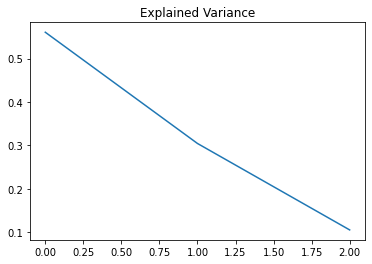

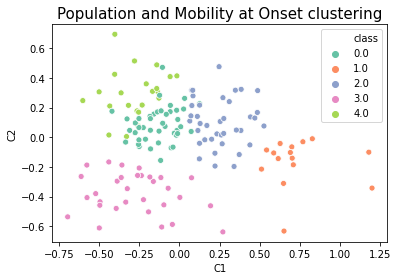

In [171]:
#vars = ['POP_ESTIMATE_2018 (log)', 'OD_baseline (log)']
vars = [
    'OD_baseline (log)',
    'OD_at_onset_normalized',
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',
    'POP_ESTIMATE_2018 (log)',
    'onset_relative',
]
X = strat_df[vars].values.copy()
XX = X - X.min(axis=0)[None,:]
XX /= XX.max(axis=0)[None,:]
pca = PCA(n_components=3, svd_solver='full')
XXX = pca.fit_transform(XX)

clustering = KMeans(n_clusters=5, random_state=0).fit(XXX)
#clustering = AgglomerativeClustering(n_clusters=6, linkage='average', affinity='euclidean').fit(XX)
strat_df['strat_class'] = clustering.labels_

plt.plot(np.arange(XXX.shape[1]), pca.explained_variance_ratio_); plt.title('Explained Variance')

f,ax=plt.subplots()
g = sns.scatterplot(
    x='C1',
    y='C2',
    data=pd.DataFrame(data=np.hstack((XXX, clustering.labels_[:,None])),columns=['C1','C2','C3','class']),
    hue='class',
    palette="Set2",
    ax=ax
)

plt.title(f'Population and Mobility at Onset clustering', y=1, fontsize=15)
plt.show()

In [172]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
strat_class = 0
target_var = 'day_28_normalized'

X = strat_df[strat_df['strat_class'] == strat_class][predictor_vars].copy()
y = strat_df[strat_df['strat_class'] == strat_class][target_var].copy()

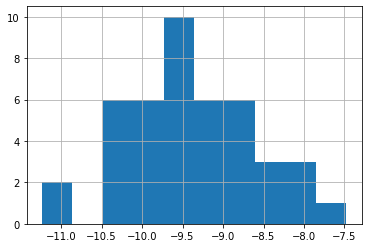

In [174]:
strat_df[strat_df['strat_class'] == strat_class]['day_28_normalized'].transform('log').hist()

In [224]:
scaler = MinMaxScaler()
XX = scaler.fit_transform(X)

glm = sm.GLM(y, sm.add_constant(XX), family=sm.families.Gaussian(sm.families.links.log))
glm = glm.fit()

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  after removing the cwd from sys.path.


In [225]:
print(glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      day_28_normalized   No. Observations:                   43
Model:                            GLM   Df Residuals:                       29
Model Family:                Gaussian   Df Model:                           13
Link Function:                    log   Scale:                      2.8035e-09
Method:                          IRLS   Log-Likelihood:                 369.37
Date:                Fri, 19 Jun 2020   Deviance:                   8.1302e-08
Time:                        23:40:08   Pearson chi2:                 8.13e-08
No. Iterations:                    17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3602      4.753      0.917      0.3

In [264]:
r2_score(y, glm_results.predict(sm.add_constant(XX)))

0.8208610427543787

In [263]:
pd.DataFrame(np.vstack((glm.pvalues[1:][None,:],glm.params[1:][None,:])), columns=predictor_vars).rename(index={0:'pvalues', 1:'coef'})

,onset_relative,OD_baseline (log),OD_at_onset_normalized,OD_at_onset (log),OD_2wk_before_onset_normalized,POP Density (log),Housing Density (log),POP_ESTIMATE_2018 (log),Beds_normalized,HospCt_normalized,Total_age65plus_normalized,POVALL_2018_normalized,BAHN_normalized
pvalues,0.037146,0.006817,0.006314,0.006564,0.180389,0.000001,0.000004,0.318465,0.389897,0.044762,0.000015,0.828363,0.161067
coef,-1.364337,-390.637233,-58.994045,413.882462,-1.146834,29.948074,-28.916309,-1.506822,0.631367,-0.991185,5.360240,-0.163011,0.975838
